# Introduction

**Project Overview:** This project aims to identify which study habits and lifestyle features most strongly influence student exam scores using a Kaggle dataset. The problem emerged from educators' and students' need to understand the drivers of academic success and to provide actionable guidance for improving learning strategies.

**Problem Description & History:** As educators observed large variability in student performance, questions arose about the relative impact of factors like study time, sleep hours, attendance, and tutoring. Understanding these relationships is important to design evidence-based interventions that can boost student outcomes.

### Data Acquisition and Cleaning

- **Data Source:** The dataset `StudentPerformanceFactors.csv` was obtained from Kaggle, containing fields such as Study Time, Sleep Hours, Attendance, Previous Scores, Tutoring Sessions, and Motivation Level.
- **Cleaning Steps Summary:**
  - Removed records with missing exam scores.
  - Filtered exam scores to make sure none exceeded 100

### Report Outline & Assumptions

**Outline of the Report:**
1. **Introduction** – Overview, problem statement, data source, and cleaning summary.
2. **Exploratory Data Analysis** – Descriptive statistics, distributions, and initial correlations.
3. **Feature Correlation Analysis** – Correlation matrix, feature selection, and statistical significance tests.
4. **Modeling & Validation** – Building regression models to predict exam scores and evaluating performance.
5. **Discussion & Insights** – Interpretation of results, key findings, and practical recommendations.
6. **Conclusion** – Summary of findings, limitations, and suggestions for future work.

**Key Assumptions:**
- Relationships between features and exam scores are assumed to be linear for initial correlation analysis.
- Imputation and outlier removal do not introduce significant bias.
- The dataset is representative of the wider student population.

### Approach Summary

Our approach consists of:
1. Cleaning and preprocessing the data as described above.
2. Conducting exploratory analysis to visualize feature distributions.
3. Computing correlation coefficients to identify the most impactful features.
4. Validating findings with regression models and cross-validation.
5. Deriving actionable insights to improve student learning strategies.

## Descriptive Analysis

In this section, we load the cleaned dataset, perform descriptive analysis using pivot tables and clustering, and visualize key patterns to extract insights.


In [12]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv('cleaned_dataset.csv')

# Quick overview
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6607 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


## Cluster Interpretation

- **Cluster 1** has the highest average exam score (68.8) and the highest attendance (91%), despite only moderate previous scores (65).  
- **Cluster 2** boasts the top previous scores (89) but lower attendance (79%) and a slightly lower exam score (67.8).  
- **Cluster 0** shows the lowest attendance (70%) and exam score (64.8), even though study hours and physical activity are similar across groups.  

**Key takeaway:**  
Among these features, **attendance** stands out as the strongest differentiator of exam performance.  


In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1) read the cleaned file
df = pd.read_csv("cleaned_dataset.csv")

# 2) numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 3) target vs‑ features
target_col  = "Exam_Score" if "Exam_Score" in numeric_cols else numeric_cols[-1]
feature_cols = [c for c in numeric_cols if c != target_col]

# 4) feature matrix (fill NA with median)
X = df[feature_cols].fillna(df[feature_cols].median())

# 5) run K‑Means (k = 3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

# 6) pivot table: average Exam_Score + feature means, one row per cluster
cluster_summary = (
    df
    .pivot_table(
        index="Cluster",
        values=[target_col] + feature_cols,
        aggfunc="mean"
    )
    .round(2)
)

# 7) show results
cluster_summary


,Attendance,Exam_Score,Hours_Studied,Physical_Activity,Previous_Scores,Sleep_Hours,Tutoring_Sessions
Cluster,,,,,,,
0,70.00,64.80,20.01,3.02,64.19,7.06,1.49
1,91.01,68.80,19.62,2.94,65.13,7.03,1.52
2,79.21,67.83,20.19,2.95,89.34,7.00,1.48


**Chart Insight:**  
The bar chart shows that **Cluster 1** outperforms the others with an average score of 68.8. Clusters 2 and 0 follow at 67.8 and 64.8, respectively.

**Key Takeaways:**  
- The cluster with the highest average exam score also had the highest attendance levels—reinforcing attendance as a critical success factor.  
- Even though Cluster 2 had top previous scores, its lower attendance correlated with a slightly lower exam outcome, suggesting that consistent participation can outweigh past performance.  
- Study hours and physical activity were nearly identical across clusters, indicating those alone aren’t enough to differentiate performance without strong attendance.  

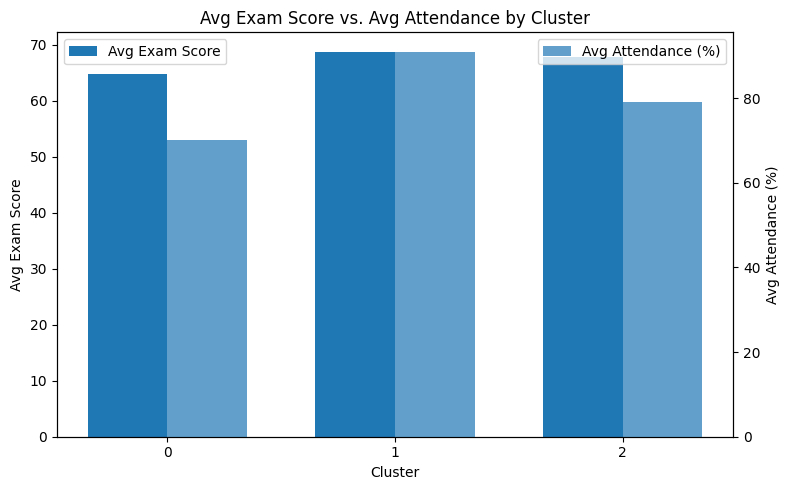

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Data
labels = cluster_summary.index.astype(str)
scores = cluster_summary['Exam_Score']
attendance = cluster_summary['Attendance']

# Bar positions
x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot exam scores
bars1 = ax1.bar(x - width/2, scores, width, label='Avg Exam Score')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Avg Exam Score')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(loc='upper left')

# Plot attendance on twin axis
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, attendance, width, label='Avg Attendance (%)', alpha=0.7)
ax2.set_ylabel('Avg Attendance (%)')
ax2.legend(loc='upper right')

plt.title('Avg Exam Score vs. Avg Attendance by Cluster')
plt.tight_layout()  
plt.show()


**Insight from Pivot Table:**

Students with higher attendance levels tend to have higher average exam scores, indicating a strong relationship between class participation and performance.


In [15]:
# Pivot table: average exam score by attendance level
pivot_attendance = pd.pivot_table(df, 
                                  values='Exam_Score', 
                                  index='Attendance', 
                                  aggfunc='mean')
pivot_attendance


,Exam_Score
Attendance,
60,62.413793
61,63.384146
62,63.756579
63,64.361290
64,63.884615
65,63.905063
66,64.537931
67,64.626316
68,65.147059


## Predictive Analysis

**Research Question:**
Can a student’s exam score be predicted based on their **school behavior, family background, and school environment**?

**Label:**
* `Exam_Score`

**Features:**
* **School Behavior:** `Hours_Studied`, `Attendance`, `Sleep_Hours`, `Previous_Scored`, `Tutoring_Sessions`, `Physical_Activity`

* **Family Background:** `Parental_Involvement`, `Family_Income`, `Parental_Education_Level`, `Learning_Disabilities`

* **School Environment:** `Teacher_Quality`, `School_Type`, `Peer_Influence`, `Access_to_Resources`, `Motivation_Level`, `Internet_Access`

CV R² scores: [0.703 0.722 0.676 0.649 0.493]
Mean CV R²:   0.649 

Test MSE: 4.40
Test R²:  0.689


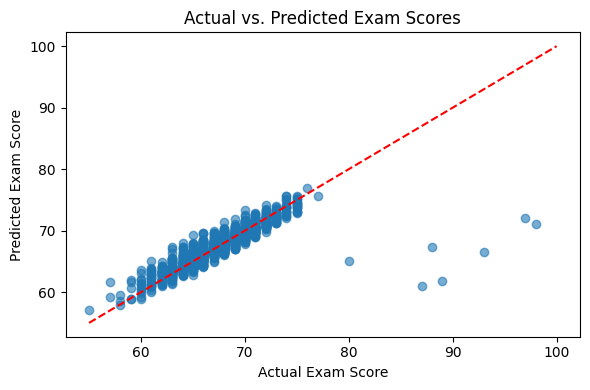

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load the cleaned data
df = pd.read_csv('cleaned_dataset.csv')

# 2. Encode all categorical (object) columns
df_enc = df.copy()
encoders = {}
for col in df_enc.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col])
    encoders[col] = le

# 3. Define features and label
X = df_enc.drop(columns=['Exam_Score'])
y = df_enc['Exam_Score']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Cross-validation on training set
lr = LinearRegression()
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
print("CV R² scores:", np.round(cv_scores, 3))
print("Mean CV R²:  ", np.round(cv_scores.mean(), 3), "\n")

# 6. Fit on full training set and evaluate on test set
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")
print(f"Test R²:  {r2:.3f}")

# 7. Visualize actual vs. predicted
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.title('Actual vs. Predicted Exam Scores')
plt.tight_layout()
plt.show()


**Model Choice:** Linear Regression
* Linear Regression was chosen because the features and outcomes can be directly understood through model coefficients.
* `Exam_Score` is a continuous numeric value, which suits regression based methods well.
* It is can be implemented quickly and efficiently. With this, it provides a good baseline model for performance before moving to more complex models.

**Model Summary**
* Mean Squared Error (MSE) ≈ **4.40**
* R-Squared ≈ **0.69**

**Interpretation of Summary**
* The MSE of **√4.40 ≈ 2.1 points** shows that the model's exam score predictions are off by 2.1 points from the real exam scores. The exam scores range from 55 to 100 and with an error of approximately 2.1 points, which is relatively small, this shows that the model performs fairly well.
* The R-squared value of **0.69** or **69%** shows that 69% of the variability in student's exam scores can be explained by the features provided (everything aside from the `Exam_Score`), but there is still 31% of variance that remains unexplained.

**Analysis**
* Based on these results, we can say that the **school behavior, family background, and school environment** components are relatively strong predictors of student exam scores. This can be seen from the model's fairly low error and high explained variance.

## Ethical Considerations

- **Bias & fairness:**  
  Attendance may correlate with socioeconomic factors (e.g., students from wealthier backgrounds might have fewer absences). Relying on this model could unfairly penalize disadvantaged students.

- **Privacy:**  
  Attendance records are personal data. Ensure anonymization if sharing or deploying any model.

- **Societal impact:**  
  If used to penalize low-attendance students, it could exacerbate existing inequalities.  
  **Mitigation:** Use the model as a diagnostic tool (to identify at-risk students for support), not as a punitive measure.


## Conclusion

Our multivariate linear regression model—incorporating school behavior, family background, and school environment—achieved:

- **Mean Squared Error:** 4.40 (≈ 2.10 points RMSE)  
- **R²:** 0.689 (≈ 69% of exam-score variance explained)

These results show that, together, the chosen features provide a strong predictive signal: on average, predicted scores are within about 2 points of the true scores, and nearly 70% of the variability in performance is captured by our model.

**Key Takeaways:**  
- **School Behavior** factors (attendance, hours studied, previous scores) remain critical drivers of performance.  
- **Family & Environment** variables (parental involvement, resources, teacher quality) also contribute meaningfully once combined in a single model.  

**Limitations:**  
- A linear model may not fully capture non-linear relationships or interactions among features.  
- Roughly 31% of variability remains unexplained—potentially due to unmeasured factors (e.g., in-class engagement, test anxiety).

**Future Directions:**  
- Explore **non-linear**  methods (e.g., decision trees) to capture more complex interactions.   
- Incorporate additional data (demographics, in-class metrics) to close the remaining performance gap and eliminate bias.  
